In [1]:
from konlpy.tag import Mecab
from collections import Counter

import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D
from tensorflow.keras.layers import Input, Conv1D, Dropout, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [8]:
class ClassifierModel():
    def __init__(self, datasets=[{ 'name': 'preprocessed_train', 'frac': 1 }]):
        super(ClassifierModel, self).__init__()
        
        self.tokenizer = Mecab()
        self.stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
        
        self.vocab_size = None
        self.word_vector_dim = 128
        
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.x_val = None
        self.y_val = None
        
        self.preprocess(datasets)
        
        self.model = self.CNN()
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        self.history = None
        self.es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

    
    def data_load(self, datasets):
        
        _dir = '../../data'
        dfs = []
        for it in datasets:
            _df = pd.read_csv(f'{_dir}/{it["name"]}.csv')
            _df = _df.sample(frac=it['frac'])
                
            dfs.append(_df)
            
        df = pd.concat(dfs)
        df.drop_duplicates(inplace=True)
        
        return df
    

    def preprocess_sentence(self, sentence):

        sentence = sentence.lower().strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
        sentence = sentence.strip()

        return sentence
    
    
    def tokenize(self, it):
        result = []
        for sentence in it:
            temp = self.tokenizer.morphs(sentence)
            temp = [word for word in temp if not word in self.stopwords] 
            result.append(temp)
        return result
    
    
    def pad_sequences(self, it, word_to_index):
        return tf.keras.preprocessing.sequence.pad_sequences(
            it, value=word_to_index["<PAD>"], padding='pre', maxlen=70)
    
    
    def preprocess(self, datasets):
        
        df = self.data_load(datasets)
        df['data'] = df['data'].apply(lambda it : self.preprocess_sentence(it))
        
        X = self.tokenize(df['data'])
        Y = tf.keras.utils.to_categorical(df['label'], num_classes=4, dtype='float32')
        
        x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
        
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        
        words = np.concatenate(x_train).tolist()
        counter = Counter(words)
        counter = counter.most_common(10000-4)
        vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
        word_to_index = { word:index for index, word in enumerate(vocab) }
        
        self.vocab_size = len(word_to_index)
        
        def wordlist_to_index_list(wordlist):
            return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
        x_train = list(map(wordlist_to_index_list, x_train))
        x_test = list(map(wordlist_to_index_list, x_test))
        x_val = list(map(wordlist_to_index_list, x_val))  
        
        self.x_train = self.pad_sequences(x_train, word_to_index)
        self.x_val = self.pad_sequences(x_val, word_to_index)
        self.x_test = self.pad_sequences(x_test, word_to_index)
    

    def CNN(self):
    
        inputs = Input(shape=(None, ))
        embedding = Embedding(self.vocab_size, self.word_vector_dim)(inputs)

        branches = []
        for filter_size in [3, 3]:
            branch = Conv1D(64, filter_size, activation='relu')(embedding)
            branch = GlobalMaxPooling1D()(branch)
            branches.append(branch)

        out = Concatenate()(branches)
        out = Dense(32, activation='relu')(out)
        out = Dropout(0.5)(out)

        out = Dense(4, activation='softmax')(out)
        model = Model(inputs=inputs, outputs=out)

        return model
    
    def train(self):
        self.history = self.model.fit(
            self.x_train, self.y_train, epochs=20, batch_size=64,
            validation_data=(self.x_val, self.y_val), callbacks=self.es, verbose=1)
        
    def show_report(self):
        y_pred = self.model.predict(self.x_test).argmax(axis=1)
        y_true = self.y_test.argmax(axis=1)
        
        print(f'accuracy : {accuracy_score(y_true, y_pred)}')
        print(f'macro f1 : {f1_score(y_true, y_pred, average="macro")}')
        print(f'weighted f1 : {f1_score(y_true, y_pred, average="weighted")}')
        
        conf_matrix = confusion_matrix(y_true, y_pred)
        names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘"]
        conf_matrix = pd.DataFrame(conf_matrix, index=names, columns=names)
        sns.heatmap(conf_matrix, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.show()

Epoch 1/20
119/119 [==============================] - 5s 9ms/step - loss: 1.1423 - accuracy: 0.5220 - val_loss: 0.7027 - val_accuracy: 0.7751
Epoch 2/20
119/119 [==============================] - 1s 5ms/step - loss: 0.5872 - accuracy: 0.8064 - val_loss: 0.3722 - val_accuracy: 0.8810
Epoch 3/20
119/119 [==============================] - 1s 5ms/step - loss: 0.3095 - accuracy: 0.9117 - val_loss: 0.2482 - val_accuracy: 0.9278
Epoch 4/20
119/119 [==============================] - 1s 5ms/step - loss: 0.1582 - accuracy: 0.9589 - val_loss: 0.1925 - val_accuracy: 0.9380
Epoch 5/20
119/119 [==============================] - 1s 5ms/step - loss: 0.0883 - accuracy: 0.9792 - val_loss: 0.1784 - val_accuracy: 0.9477
Epoch 6/20
119/119 [==============================] - 1s 5ms/step - loss: 0.0546 - accuracy: 0.9867 - val_loss: 0.1804 - val_accuracy: 0.9443
Epoch 7/20
119/119 [==============================] - 1s 5ms/step - loss: 0.0409 - accuracy: 0.9888 - val_loss: 0.1703 - val_accuracy: 0.9540
Epoch 

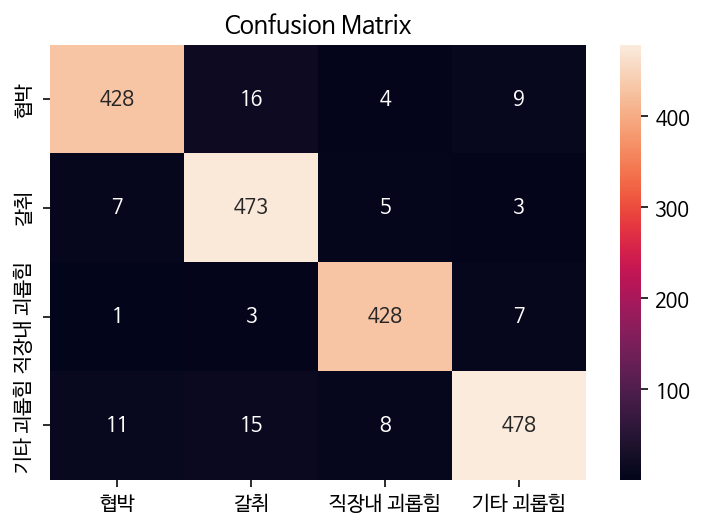

In [9]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rs', 'frac': 1 },
    { 'name': 'train_rd', 'frac': 1 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
99/99 [==============================] - 2s 10ms/step - loss: 1.2325 - accuracy: 0.4657 - val_loss: 0.9218 - val_accuracy: 0.6942
Epoch 2/20
99/99 [==============================] - 1s 5ms/step - loss: 0.7393 - accuracy: 0.7358 - val_loss: 0.5389 - val_accuracy: 0.8122
Epoch 3/20
99/99 [==============================] - 1s 5ms/step - loss: 0.4506 - accuracy: 0.8603 - val_loss: 0.4230 - val_accuracy: 0.8552
Epoch 4/20
99/99 [==============================] - 1s 5ms/step - loss: 0.2753 - accuracy: 0.9255 - val_loss: 0.3743 - val_accuracy: 0.8699
Epoch 5/20
99/99 [==============================] - 1s 5ms/step - loss: 0.1668 - accuracy: 0.9525 - val_loss: 0.3398 - val_accuracy: 0.8876
Epoch 6/20
99/99 [==============================] - 0s 5ms/step - loss: 0.1020 - accuracy: 0.9737 - val_loss: 0.3523 - val_accuracy: 0.8866
Epoch 7/20
99/99 [==============================] - 0s 5ms/step - loss: 0.0670 - accuracy: 0.9824 - val_loss: 0.3735 - val_accuracy: 0.9008
Epoch 8/20
99/99 [=

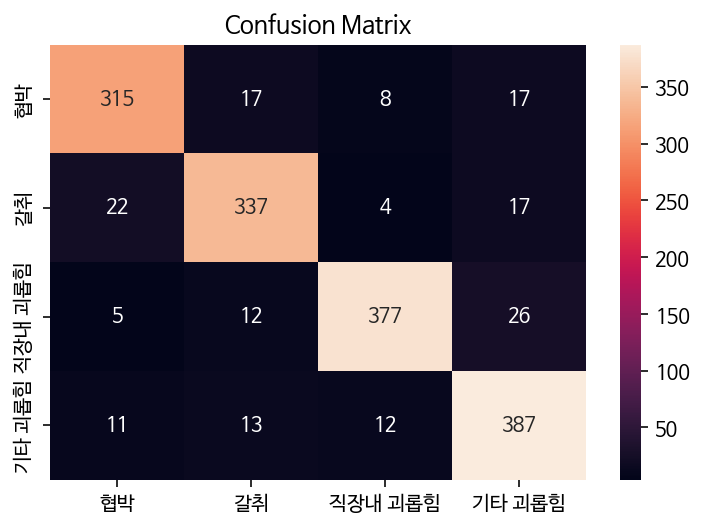

In [10]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rs', 'frac': 1 },
    { 'name': 'train_bt_en', 'frac': 0.5 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
99/99 [==============================] - 1s 7ms/step - loss: 1.2355 - accuracy: 0.4657 - val_loss: 0.9516 - val_accuracy: 0.6739
Epoch 2/20
99/99 [==============================] - 1s 5ms/step - loss: 0.7431 - accuracy: 0.7421 - val_loss: 0.5603 - val_accuracy: 0.8015
Epoch 3/20
99/99 [==============================] - 1s 5ms/step - loss: 0.4543 - accuracy: 0.8560 - val_loss: 0.4412 - val_accuracy: 0.8400
Epoch 4/20
99/99 [==============================] - 1s 5ms/step - loss: 0.2787 - accuracy: 0.9207 - val_loss: 0.4190 - val_accuracy: 0.8608
Epoch 5/20
99/99 [==============================] - 0s 5ms/step - loss: 0.1682 - accuracy: 0.9538 - val_loss: 0.3810 - val_accuracy: 0.8805
Epoch 6/20
99/99 [==============================] - 1s 5ms/step - loss: 0.0985 - accuracy: 0.9778 - val_loss: 0.3924 - val_accuracy: 0.8815
Epoch 7/20
99/99 [==============================] - 0s 5ms/step - loss: 0.0618 - accuracy: 0.9858 - val_loss: 0.4041 - val_accuracy: 0.8876
Epoch 8/20
99/99 [==

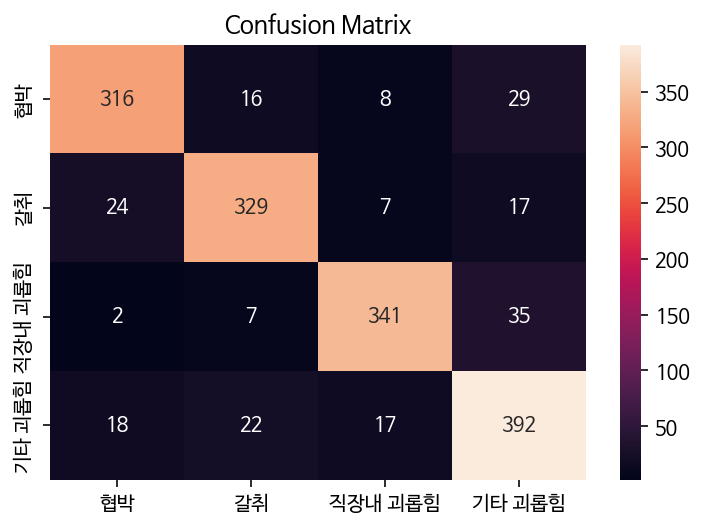

In [17]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rs', 'frac': 1 },
    { 'name': 'train_bt_ja', 'frac': 0.5 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
99/99 [==============================] - 1s 8ms/step - loss: 1.2144 - accuracy: 0.4799 - val_loss: 0.8505 - val_accuracy: 0.7484
Epoch 2/20
99/99 [==============================] - 1s 5ms/step - loss: 0.6994 - accuracy: 0.7609 - val_loss: 0.5110 - val_accuracy: 0.8253
Epoch 3/20
99/99 [==============================] - 1s 5ms/step - loss: 0.4277 - accuracy: 0.8653 - val_loss: 0.4256 - val_accuracy: 0.8486
Epoch 4/20
99/99 [==============================] - 0s 5ms/step - loss: 0.2423 - accuracy: 0.9358 - val_loss: 0.3477 - val_accuracy: 0.8856
Epoch 5/20
99/99 [==============================] - 1s 5ms/step - loss: 0.1324 - accuracy: 0.9665 - val_loss: 0.3354 - val_accuracy: 0.8896
Epoch 6/20
99/99 [==============================] - 1s 5ms/step - loss: 0.0875 - accuracy: 0.9810 - val_loss: 0.3473 - val_accuracy: 0.8866
Epoch 7/20
99/99 [==============================] - 1s 5ms/step - loss: 0.0606 - accuracy: 0.9858 - val_loss: 0.3461 - val_accuracy: 0.8927
Epoch 8/20
99/99 [==

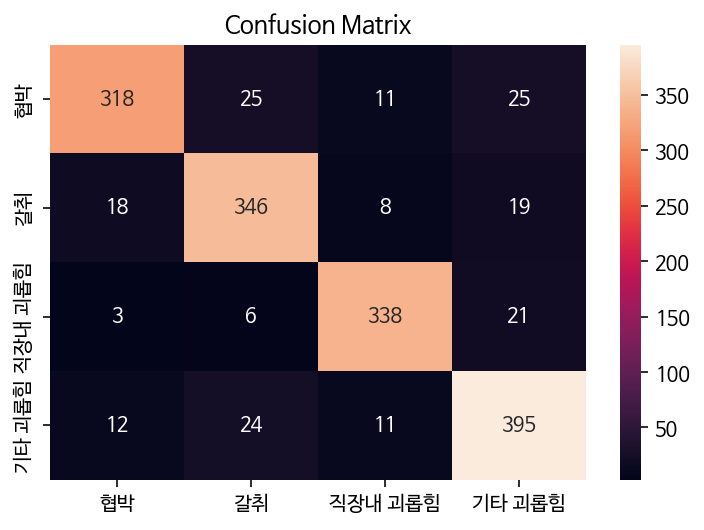

In [15]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rd', 'frac': 1 },
    { 'name': 'train_bt_en', 'frac': 0.5 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
99/99 [==============================] - 1s 7ms/step - loss: 1.2422 - accuracy: 0.4647 - val_loss: 0.9089 - val_accuracy: 0.6901
Epoch 2/20
99/99 [==============================] - 1s 5ms/step - loss: 0.7848 - accuracy: 0.7185 - val_loss: 0.5516 - val_accuracy: 0.8091
Epoch 3/20
99/99 [==============================] - 1s 5ms/step - loss: 0.4903 - accuracy: 0.8421 - val_loss: 0.4464 - val_accuracy: 0.8446
Epoch 4/20
99/99 [==============================] - 1s 5ms/step - loss: 0.3111 - accuracy: 0.9122 - val_loss: 0.3767 - val_accuracy: 0.8739
Epoch 5/20
99/99 [==============================] - 0s 5ms/step - loss: 0.1834 - accuracy: 0.9516 - val_loss: 0.3704 - val_accuracy: 0.8724
Epoch 6/20
99/99 [==============================] - 1s 5ms/step - loss: 0.1146 - accuracy: 0.9693 - val_loss: 0.3720 - val_accuracy: 0.8830
Epoch 7/20
99/99 [==============================] - 1s 5ms/step - loss: 0.0839 - accuracy: 0.9780 - val_loss: 0.3831 - val_accuracy: 0.8856
Epoch 8/20
99/99 [==

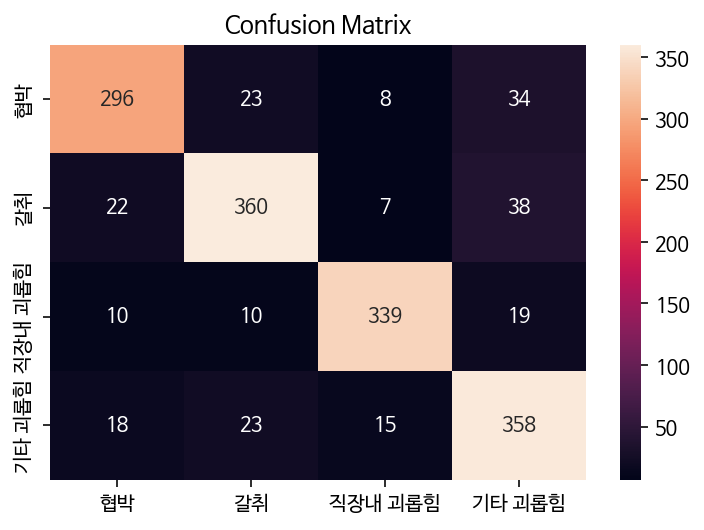

In [18]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rd', 'frac': 1 },
    { 'name': 'train_bt_ja', 'frac': 0.5 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
79/79 [==============================] - 1s 8ms/step - loss: 1.3057 - accuracy: 0.4096 - val_loss: 1.0941 - val_accuracy: 0.6399
Epoch 2/20
79/79 [==============================] - 0s 4ms/step - loss: 0.9437 - accuracy: 0.6485 - val_loss: 0.7297 - val_accuracy: 0.7481
Epoch 3/20
79/79 [==============================] - 0s 4ms/step - loss: 0.6023 - accuracy: 0.8018 - val_loss: 0.5615 - val_accuracy: 0.8165
Epoch 4/20
79/79 [==============================] - 0s 5ms/step - loss: 0.3720 - accuracy: 0.8938 - val_loss: 0.4787 - val_accuracy: 0.8386
Epoch 5/20
79/79 [==============================] - 0s 4ms/step - loss: 0.2190 - accuracy: 0.9415 - val_loss: 0.4591 - val_accuracy: 0.8411
Epoch 6/20
79/79 [==============================] - 0s 5ms/step - loss: 0.1320 - accuracy: 0.9701 - val_loss: 0.4537 - val_accuracy: 0.8468
Epoch 7/20
79/79 [==============================] - 0s 5ms/step - loss: 0.0769 - accuracy: 0.9844 - val_loss: 0.4790 - val_accuracy: 0.8551
Epoch 8/20
79/79 [==

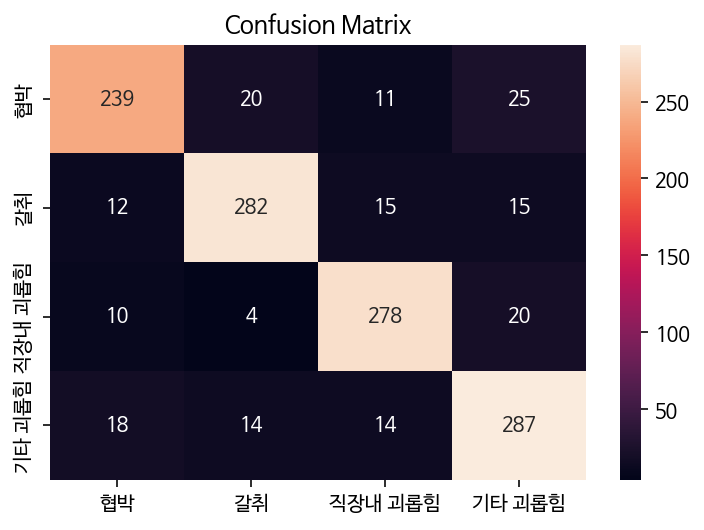

In [16]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_bt_en', 'frac': 0.5 },
    { 'name': 'train_bt_ja', 'frac': 0.5 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
139/139 [==============================] - 2s 8ms/step - loss: 1.0761 - accuracy: 0.5625 - val_loss: 0.6446 - val_accuracy: 0.7848
Epoch 2/20
139/139 [==============================] - 1s 5ms/step - loss: 0.5452 - accuracy: 0.8192 - val_loss: 0.3769 - val_accuracy: 0.8817
Epoch 3/20
139/139 [==============================] - 1s 5ms/step - loss: 0.2828 - accuracy: 0.9176 - val_loss: 0.2725 - val_accuracy: 0.9146
Epoch 4/20
139/139 [==============================] - 1s 5ms/step - loss: 0.1451 - accuracy: 0.9610 - val_loss: 0.2238 - val_accuracy: 0.9291
Epoch 5/20
139/139 [==============================] - 1s 5ms/step - loss: 0.0743 - accuracy: 0.9820 - val_loss: 0.2115 - val_accuracy: 0.9320
Epoch 6/20
139/139 [==============================] - 1s 5ms/step - loss: 0.0458 - accuracy: 0.9904 - val_loss: 0.2210 - val_accuracy: 0.9327
Epoch 7/20
139/139 [==============================] - 1s 5ms/step - loss: 0.0374 - accuracy: 0.9904 - val_loss: 0.2057 - val_accuracy: 0.9400
Epoch 

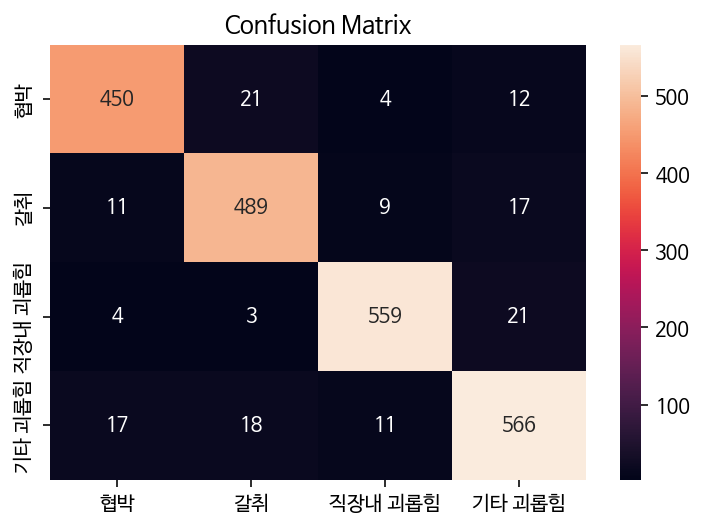

In [12]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rs', 'frac': 1 },
    { 'name': 'train_rd', 'frac': 1 },
    { 'name': 'train_bt_en', 'frac': 0.5 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
139/139 [==============================] - 1s 6ms/step - loss: 1.1477 - accuracy: 0.5150 - val_loss: 0.6762 - val_accuracy: 0.7635
Epoch 2/20
139/139 [==============================] - 1s 5ms/step - loss: 0.5892 - accuracy: 0.8026 - val_loss: 0.3954 - val_accuracy: 0.8673
Epoch 3/20
139/139 [==============================] - 1s 5ms/step - loss: 0.3346 - accuracy: 0.8977 - val_loss: 0.2854 - val_accuracy: 0.9034
Epoch 4/20
139/139 [==============================] - 1s 5ms/step - loss: 0.1789 - accuracy: 0.9497 - val_loss: 0.2395 - val_accuracy: 0.9179
Epoch 5/20
139/139 [==============================] - 1s 5ms/step - loss: 0.1045 - accuracy: 0.9722 - val_loss: 0.2264 - val_accuracy: 0.9280
Epoch 6/20
139/139 [==============================] - 1s 5ms/step - loss: 0.0703 - accuracy: 0.9795 - val_loss: 0.2317 - val_accuracy: 0.9363
Epoch 7/20
139/139 [==============================] - 1s 5ms/step - loss: 0.0499 - accuracy: 0.9859 - val_loss: 0.2405 - val_accuracy: 0.9363
Epoch 

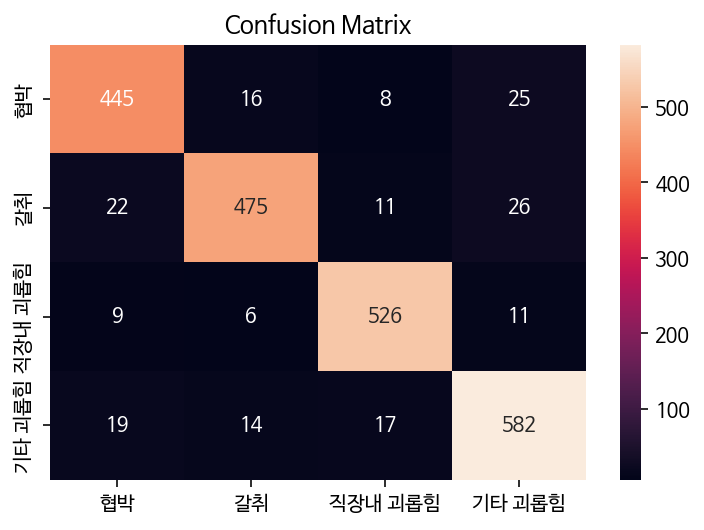

In [19]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rs', 'frac': 1 },
    { 'name': 'train_rd', 'frac': 1 },
    { 'name': 'train_bt_ja', 'frac': 0.5 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
119/119 [==============================] - 1s 8ms/step - loss: 1.2156 - accuracy: 0.4675 - val_loss: 0.8083 - val_accuracy: 0.7270
Epoch 2/20
119/119 [==============================] - 1s 5ms/step - loss: 0.6874 - accuracy: 0.7571 - val_loss: 0.5187 - val_accuracy: 0.8245
Epoch 3/20
119/119 [==============================] - 1s 5ms/step - loss: 0.4144 - accuracy: 0.8669 - val_loss: 0.3950 - val_accuracy: 0.8654
Epoch 4/20
119/119 [==============================] - 1s 5ms/step - loss: 0.2340 - accuracy: 0.9358 - val_loss: 0.3381 - val_accuracy: 0.8819
Epoch 5/20
119/119 [==============================] - 1s 5ms/step - loss: 0.1293 - accuracy: 0.9710 - val_loss: 0.3151 - val_accuracy: 0.8928
Epoch 6/20
119/119 [==============================] - 1s 5ms/step - loss: 0.0793 - accuracy: 0.9814 - val_loss: 0.3191 - val_accuracy: 0.8958
Epoch 7/20
119/119 [==============================] - 1s 5ms/step - loss: 0.0536 - accuracy: 0.9883 - val_loss: 0.3251 - val_accuracy: 0.9008
Epoch 

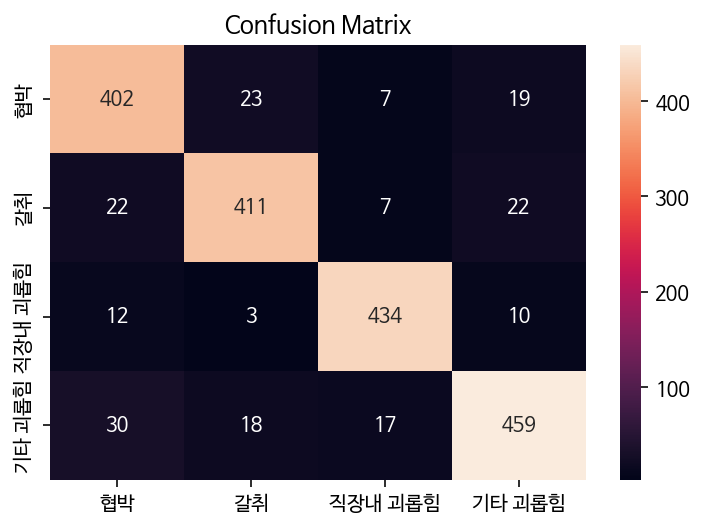

In [21]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_bt_en', 'frac': 0.5 },
    { 'name': 'train_rd', 'frac': 1 },
    { 'name': 'train_bt_ja', 'frac': 0.5 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
158/158 [==============================] - 2s 8ms/step - loss: 1.1361 - accuracy: 0.5187 - val_loss: 0.6750 - val_accuracy: 0.7747
Epoch 2/20
158/158 [==============================] - 1s 5ms/step - loss: 0.5772 - accuracy: 0.8078 - val_loss: 0.3812 - val_accuracy: 0.8750
Epoch 3/20
158/158 [==============================] - 1s 5ms/step - loss: 0.3046 - accuracy: 0.9120 - val_loss: 0.2640 - val_accuracy: 0.9127
Epoch 4/20
158/158 [==============================] - 1s 5ms/step - loss: 0.1596 - accuracy: 0.9582 - val_loss: 0.2419 - val_accuracy: 0.9193
Epoch 5/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0928 - accuracy: 0.9773 - val_loss: 0.2294 - val_accuracy: 0.9313
Epoch 6/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0578 - accuracy: 0.9864 - val_loss: 0.2453 - val_accuracy: 0.9345
Epoch 7/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0404 - accuracy: 0.9907 - val_loss: 0.2548 - val_accuracy: 0.9358
Epoch 

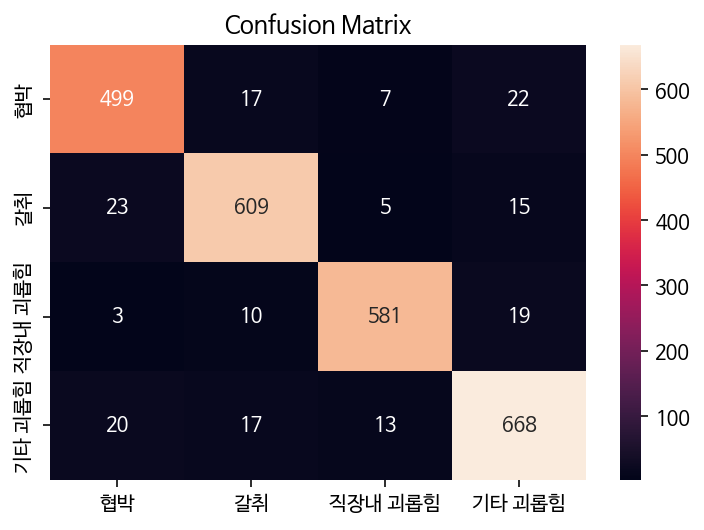

In [14]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rs', 'frac': 1 },
    { 'name': 'train_rd', 'frac': 1 },
    { 'name': 'train_bt_en', 'frac': 0.5 },
    { 'name': 'train_bt_ja', 'frac': 0.5 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()